In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx.algorithms import approximation as approx

import scipy

from itertools import combinations

# Question 4.1

In [21]:
data = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset4/data/Cooffending_data.csv")
df = data

nparr = data.to_numpy()


#### Part (a)

In [4]:
len(np.unique(nparr[:, 0]))

539593

#### Part (b)

In [5]:
len(np.unique(nparr[:, 1]))

539593

#### Part (c)

In [6]:
print(f"All years: {len(np.unique(nparr[:, 4]))}")

years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]

for year in years:
    arr = np.where(nparr[:, -1] == year)
    # print(nparr[arr][:, 4])
    num = len(np.unique(nparr[arr][:, 4]))
    print(f"{year}: {num}")


All years: 1164836
2003: 110556
2004: 121374
2005: 172664
2006: 185840
2007: 196151
2008: 199288
2009: 178959
2010: 4


#### part (d)

In [7]:
unique_crimes = np.unique(nparr[:, 4])

unique_vals, counts = np.unique(nparr[:, 4], return_counts=True)

sorted_indices = np.argsort(-counts)

sorted_unique_vals = unique_vals[sorted_indices]
sorted_counts = counts[sorted_indices]

result = np.column_stack((sorted_unique_vals, sorted_counts))

In [8]:
muns = np.zeros((10, 1))

count = 0

for i in result[:10]:
    idx = np.where(nparr[:, 4] == i[0])[0][0]

    muns[count] = nparr[idx][10]
    count += 1

print(np.column_stack((sorted_unique_vals[:10], sorted_counts[:10], muns)))

[[27849 156 66023.0]
 [876159 102 12072.0]
 [445040 77 66023.0]
 [23526 60 75017.0]
 [60815 60 54048.0]
 [212285 57 37067.0]
 [754187 56 95032.0]
 [539385 52 66023.0]
 [23610 51 78005.0]
 [453024 46 66023.0]]


#### part (e)

In [9]:
data['SeqE'] = pd.to_numeric(data['SeqE'], errors='coerce')
data['NoUnique'] = pd.to_numeric(data['NoUnique'], errors='coerce')

# Drop rows with missing SeqE or NsoUnique
# data = data.dropna(subset=['SeqE', 'NoUnique'])

# Initialize undirected graph
G = nx.Graph()

# Group by SeqE (each event)
for _, group in data.groupby('SeqE'):
    participants = group['NoUnique'].unique()
    if len(participants) > 1:
        for u, v in combinations(participants, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)

# Optional: Add isolated nodes (people with no co-offenders)
# for person in data['NoUnique'].unique():
#     if person not in G:
#         G.add_node(person)


In [10]:
print(f"Number of nodes: {G.number_of_nodes()}")

print(f"Number of solo offenders: {539593-121159}")

print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 121159
Number of solo offenders: 418434
Number of edges: 178413


### part (f)

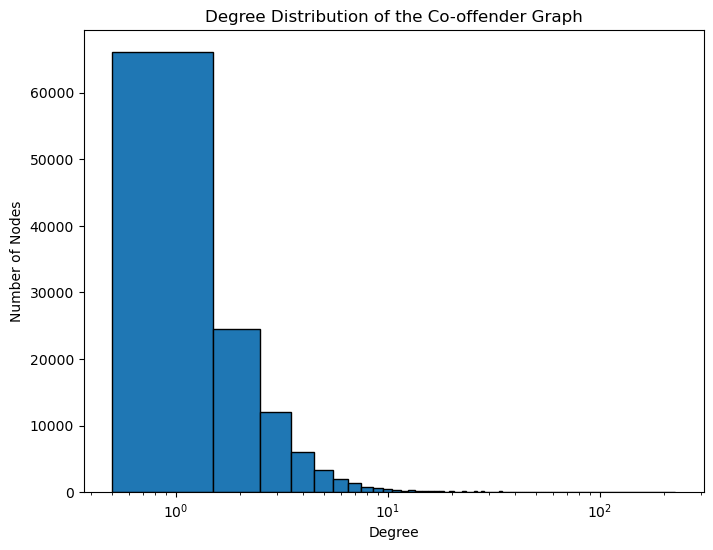

In [11]:
degree_sequence = [degree for node, degree in G.degree()]

# Plot the degree distribution as a histogram
plt.figure(figsize=(8, 6))
# Setting the bins to cover the full range of degrees; +2 ensures the last bin is included
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 2), 
         align='left', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution of the Co-offender Graph")
plt.xscale('log')
plt.savefig('deg_dist1')
plt.show()

#### part (g)

In [12]:
print(nx.number_connected_components(G))

36098


#### part (h)

In [13]:
largest_cc = max(nx.connected_components(G), key=len)

print(len(largest_cc))


19924


#### part(i)

Number of nodes in the largest connected component: 19924


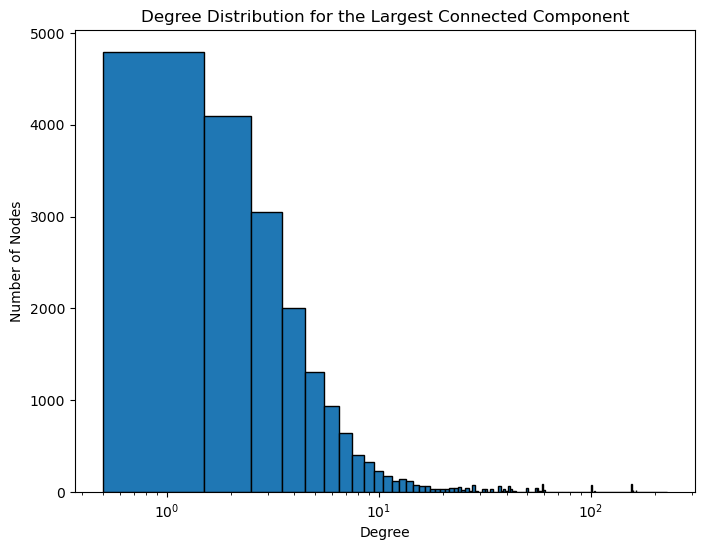

In [14]:
G_largest = G.subgraph(largest_cc)

# Compute the degree for each node in the largest connected component
degree_sequence = [deg for _, deg in G_largest.degree()]

# Print basic info about the largest component
print("Number of nodes in the largest connected component:", len(G_largest.nodes()))

# Plot the degree distribution as a histogram
plt.figure(figsize=(8, 6))
# Define bins from the minimum to maximum degree, plus one to include the max value
bins = range(min(degree_sequence), max(degree_sequence) + 2)
plt.hist(degree_sequence, bins=bins, align='left', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution for the Largest Connected Component")
plt.xscale('log')
plt.savefig('deg_dist2')
plt.show()


#### part(j)

In [ ]:
density = nx.density(G_largest)

# 2. Clustering
avg_clustering = nx.average_clustering(G_largest)   # mean of local clustering coefficients
global_clustering = nx.transitivity(G_largest)      # global clustering coefficient (transitivity)


print(f"Edge density:           {density:.4f}")
print(f"Average clustering:     {avg_clustering:.4f}")
print(f"Global clustering (T):  {global_clustering:.4f}")


Edge density:           0.0004
Average clustering:     0.4784
Global clustering (T):  0.9460


#### part(k)

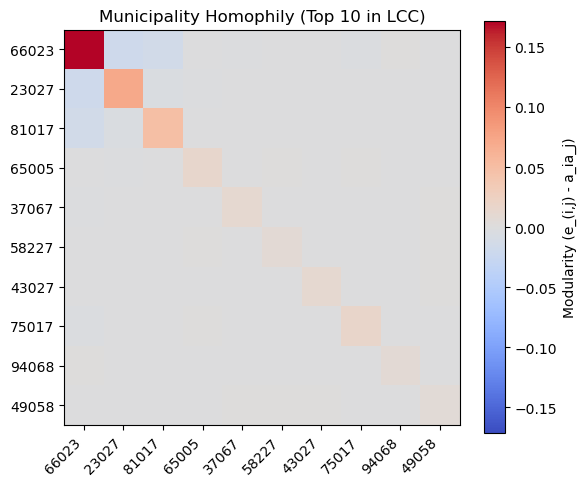

In [28]:
from collections import Counter

node2mun = df.set_index('NoUnique')['MUN'].to_dict()
nodes = [n for n in G_largest.nodes() if n in node2mun]

N = 10
mun_counts = Counter(node2mun[n] for n in nodes)
top_muns = [mun for mun, _ in mun_counts.most_common(N)]

mun2idx = { mun:i for i, mun in enumerate(top_muns) }
k = len(top_muns)

M = np.zeros((k, k), dtype=float)
for u, v in G_largest.edges():
    mu, mv = node2mun.get(u), node2mun.get(v)
    if mu in mun2idx and mv in mun2idx:
        i, j = mun2idx[mu], mun2idx[mv]
        M[i, j] += 1
        M[j, i] += 1

m = G_largest.number_of_edges()
e = M / (2 * m)    # double counting

a = e.sum(axis=1)

B = e - np.outer(a, a)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(B,
               cmap='coolwarm',
               vmin=-np.max(np.abs(B)),
               vmax= np.max(np.abs(B)),
               aspect='equal')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Modularity (e_(i,j) - a_ia_j)')

ax.set_xticks(np.arange(k))
ax.set_xticklabels(top_muns, rotation=45, ha='right')
ax.set_yticks(np.arange(k))
ax.set_yticklabels(top_muns)

ax.set_title(f"Municipality Homophily (Top {N} in LCC)")
plt.tight_layout()
plt.savefig('mun_homophily')
plt.show()


#### part(l)

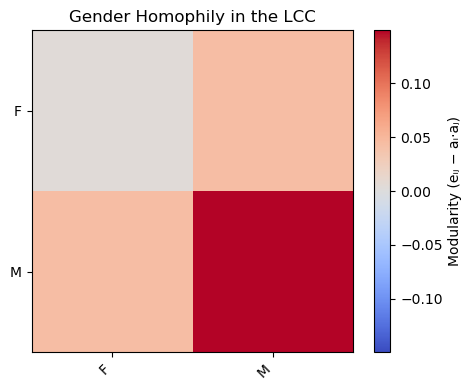

In [30]:
node2sex = df.set_index('NoUnique')['SEXE'].to_dict()

genders = sorted({ node2sex[n] for n in G_largest.nodes() if n in node2sex })
k = len(genders)
sex2idx = { sex:i for i,sex in enumerate(genders) }

M = np.zeros((k, k), dtype=float)
for u, v in G_largest.edges():
    su, sv = node2sex.get(u), node2sex.get(v)
    if su in sex2idx and sv in sex2idx:
        i, j = sex2idx[su], sex2idx[sv]
        M[i, j] += 1
        if i != j:
            M[j, i] += 1

m = G_largest.number_of_edges()
e = M / (2 * m)   # each edge counted twice

a = e.sum(axis=1)

B = e - np.outer(a, a)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(B, cmap='coolwarm',
               vmin=-np.max(np.abs(B)),
               vmax= np.max(np.abs(B)),
               aspect='equal')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Modularity (eᵢⱼ − aᵢ·aⱼ)')

ax.set_xticks(np.arange(k))
ax.set_xticklabels(genders, rotation=45, ha='right')
ax.set_yticks(np.arange(k))
ax.set_yticklabels(genders)

ax.set_title("Gender Homophily in the LCC")
plt.tight_layout()
plt.savefig("gender_homophily")
plt.show()